In [1]:
import sys
import pickle

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.metrics import make_scorer, confusion_matrix, accuracy_score, precision_score
from xgboost import XGBClassifier
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe
from functools import partial

sys.path.append("../modules/")

from tests import train_test_split_intime, train_test_split_kfold
from tests import test_intime, test_kfold

latter_size = 14
plt.rcParams['legend.fontsize'] = latter_size 
plt.rcParams['font.size'] = latter_size 
plt.rcParams['axes.labelsize'] = latter_size
plt.rcParams['xtick.labelsize'] = latter_size
plt.rcParams['ytick.labelsize'] = latter_size

In [2]:
df_train = pd.read_pickle('../../data/data_train.pkl')
df_test = pd.read_pickle('../../data/data_test.pkl')

In [3]:
target = 'discretize_s4'
predictors = [i for i in df_train.columns if i not in target]
score_function = partial(precision_score, average='macro')

## Teste básico com validação cruzada

Número de amostras da classe 1.0: 155
Número de amostras da classe 0.0: 945
Fold: 01, Score: 0.596419, Loss: 0.403581
Número de amostras da classe 1.0: 155
Número de amostras da classe 0.0: 946
Fold: 02, Score: 0.426230, Loss: 0.573770
Número de amostras da classe 1.0: 155
Número de amostras da classe 0.0: 946
Fold: 03, Score: 0.553571, Loss: 0.446429
Número de amostras da classe 1.0: 156
Número de amostras da classe 0.0: 946
Fold: 04, Score: 0.683333, Loss: 0.316667
Número de amostras da classe 1.0: 156
Número de amostras da classe 0.0: 946
Fold: 05, Score: 0.740171, Loss: 0.259829
Número de amostras da classe 1.0: 156
Número de amostras da classe 0.0: 946


/var/lib/jupyterhub/anaconda/envs/dscience/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Fold: 06, Score: 0.430328, Loss: 0.569672
Número de amostras da classe 1.0: 156
Número de amostras da classe 0.0: 946
Fold: 07, Score: 0.602011, Loss: 0.397989
Número de amostras da classe 1.0: 156
Número de amostras da classe 0.0: 946
Fold: 08, Score: 0.599440, Loss: 0.400560
Número de amostras da classe 1.0: 156
Número de amostras da classe 0.0: 946
Fold: 09, Score: 0.429167, Loss: 0.570833
Número de amostras da classe 1.0: 156
Número de amostras da classe 0.0: 946
Fold: 10, Score: 0.635897, Loss: 0.364103
Score: 0.569657 0.104410, Loss: 0.430343 0.104410


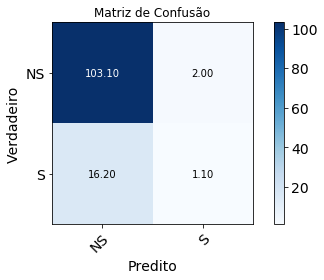

In [4]:
# simple Kfold cross validation
mod = XGBClassifier(objective="binary:hinge", metric="logloss")

test_kfold(df_train=df_train, 
           df_test=df_test,
           mod=mod,
           score_function=score_function,
           target=target)

## Teste básico com separação no tempo

Número de amostras da classe 1.0: 173
Número de amostras da classe 0.0: 1051
Score: 0.569149, Loss: 0.430851


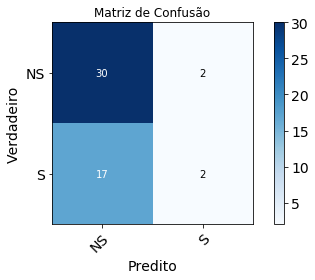

In [5]:
mod = XGBClassifier(objective="binary:hinge", metric="logloss")

test_intime(df_train=df_train, 
            df_test=df_test,
            mod=mod,
            score_function=score_function,
            target=target)

# Otimização de hiper-paramêtros

In [ ]:
def _generate_space_hyperopt(space):
    space_hyperopt = {}
    for i in space:
        space_hyperopt[i] = hp.choice(i, space[i])
        
    return space_hyperopt

In [ ]:
from tests import test_kfold_hyperopt
from tests import train_test_split_kfold

In [ ]:
score = partial(test_kfold_hyperopt,
                df_train=df_train,
                df_test=df_test,
                mod=XGBClassifier,
                score_function=score_function,
                target=target,
                early_stopping_rounds=20)

In [ ]:
def optimize(score, space, config, random_state=42, max_evals=1000):
    """
    This is the optimization function that given a space (space here) of 
    hyperparameters and a scoring function (score here), finds the best hyperparameters.
    """
    # To learn more about XGBoost parameters, head to this page: 
    # https://github.com/dmlc/xgboost/blob/master/doc/parameter.md
    
    # Use the fmin function from Hyperopt to find the best hyperparameters
    space_plus_config = {**space, **config}
    best = fmin(score,
                space_plus_config,
                algo=tpe.suggest, 
                # trials=trials, 
                max_evals=max_evals)
    
    return best

In [ ]:
space = {'n_estimators': [int(x) for x in np.linspace(start=100, stop=3000, num=15)],
         'learning_rate': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.2, 0.3],
         'max_depth':  np.arange(5, 20, dtype=int),
         'min_child_weight': np.arange(0, 20, dtype=int),
         'subsample': [0.3, 0.5, 0.75, 1.0],
         'gamma': [.3, .5, .7, .9, 1.0],
         'colsample_bytree': [.3, .5, .7, .9, 1.0],
         'scale_pos_weight': np.arange(0, 10, dtype=int),
         'colsample_bylevel': [.3, .5, .7, .9, 1.0]
        }

config = {'eval_metric': 'auc',
          'objective': 'binary:logistic',
          # Increase this number if you have more cores. Otherwise, remove it and it will default 
          # to the maxium number. 
          'nthread': 8,
          'booster': 'gbtree',
          'tree_method': 'exact',
          'silent': 1,
          'seed': 42
         }

In [ ]:
space_hyperopt = _generate_space_hyperopt(space)

In [ ]:
best_hyperparams = optimize(score=score,
                            max_evals=100000,
                            space=space_hyperopt,
                            config=config)

In [ ]:
best_values = {}
for i in best_hyperparams:
    best_values[i] = space[i][best_hyperparams[i]]
best_hyperparams = best_values
best_hyperparams = {**best_hyperparams, **config}

pickle_out = open("best_hyperparams_simple.pickle","wb")
pickle.dump(best_hyperparams, pickle_out)
pickle_out.close()

In [ ]:
subband_representation_Xmod = XGBClassifier(**best_hyperparams)

test_intime(df_train,
            df_test,
            train_test_split_intime,
            mod,
            score_function,
            predictors,
            target,
            early_stopping_rounds=20)